# Introduction to Quantum Mechanics

<center><img src="../figures/qubit.svg" alt="drawing" width="800"/></center>

# Classical Bit vs Qubit

| Feature              | Classical Bit                          | Qubit                                          |
|----------------------|----------------------------------------|-----------------------------------------------|
| **Possible States**   | 0 or 1                                 | Superposition: α|0⟩ + β|1⟩                     |
| **Representation**    | Physical state (voltage, magnetic, etc.) | Quantum system (spin, photon polarization, superconducting circuit) |
| **State Space**       | 2 discrete states                       | Infinite states on the Bloch sphere          |
| **Operations**        | Deterministic logic gates: AND, OR, NOT | Unitary, reversible gates: X, H, Z, rotations, controlled gates |
| **Measurement**       | Reading does not change the bit         | Collapses state to 0 or 1 with probabilities |α|² and |β|² |
| **Information Capacity** | Stores one binary value                | Still yields one classical bit when measured, but allows superposition-based computation |


## Superposition

In quantum mechanics, a system can exist in multiple states *at the same time*.  
A qubit state is written as:

$$|\psi\rangle = \alpha |0\rangle + \beta |1\rangle$$
where \(\alpha\) and \(\beta\) are complex amplitudes with  $|\alpha|^2 + |\beta|^2 = 1$

Key ideas:
- Superposition is a **coherent combination** of basis states.
- The amplitudes determine both **probabilities** and **relative phase**.
- Interference arises because the system is not in one state or the other, but in **both simultaneously**.

## Measurement Collapse

When a quantum state is measured, the superposition is lost and the system takes a **single definite value**.

For a state

$$
|\psi\rangle = \alpha |0\rangle + \beta |1\rangle,
$$

a measurement gives:
- $|0\rangle$ with probability  $|\alpha|^2 $
- $|1\rangle$ with probability  $|\beta|^2 $

After the outcome is observed, the state **collapses** to that outcome.  
Collapse is non-unitary and depends on the measurement basis.

### Introduction

During this course we are going to use `Qibo`, an open source framework for quantum computing. It provides us with an high level language which can be used to implement algorithms with both circuit-based and adiabatic computation approaches and, once the code is set up, it can be easily executed on various engines, including both classical and quantum hardware. 

<center><img src="../figures/qibo_ecosystem.svg" alt="drawing" width="800"/></center>

For more info about the whole framework one can have a look to the [`qibo` webpage](https://qibo.science/).

A crucial step is the backend choice. In qibo four backends are provided, and can be used for different kind of applications.

<center><img src="../figures/backends.svg" alt="drawing" width="800"/></center>

The blue backends correspond to classical hardware, while the red one can be selected if we want to execute our algorithm directly on a quantum computer.

In [2]:
# some imports from qibo + numpy
import numpy as np
import qibo
from qibo import Circuit, gates, hamiltonians

In [3]:
# with the following line we set the desired backend
qibo.set_backend(backend="numpy")

[Qibo 0.2.22|INFO|2025-11-12 09:14:07]: Using numpy backend on /CPU:0


### Build my first `qibo` circuit

Now we are ready to code our first quantum circuit using `qibo`.

In [4]:
# set the number of qubits
nqubits = 4

# we initialise the circuit using the Circuit class
c = Circuit(nqubits=nqubits)

c.draw()

0: ─
1: ─
2: ─
3: ─


We can now fill the circuits with some quantum gates. Here are some of the quantum gates which are available in Qibo.
<center><img src="../figures/gates.png" alt="drawing" width="400"/></center>
Let's apply a $X$ gate on the first qubit and a $H$ gate on the third qubit:

In [5]:
c.add(gates.X(0))
c.add(gates.H(2))
c.draw()

0: ─X─
1: ───
2: ─H─
3: ───


Finally we add measurements gate on all qubits.

In [6]:
c.add(gates.M(i) for i in range(4))
c.draw()

0: ─X─M─
1: ─M───
2: ─H─M─
3: ─M───


In [7]:
result = c(nshots=1000)

In [8]:
print(result) # visualize ket
print(result.state()) # visualize state in computational basis
print(result.probabilities()) # visualize probabilities
print(result.samples()) # visualize samples
print(result.frequencies()) # visualize frequencies

(0.70711+0j)|1000> + (0.70711+0j)|1010>
[0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.70710678+0.j 0.        +0.j 0.70710678+0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
[0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0.  0. ]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [1 0 1 0]
 [1 0 0 0]
 [1 0 1 0]]
Counter({'1010': 519, '1000': 481})


We can now visualize the state.

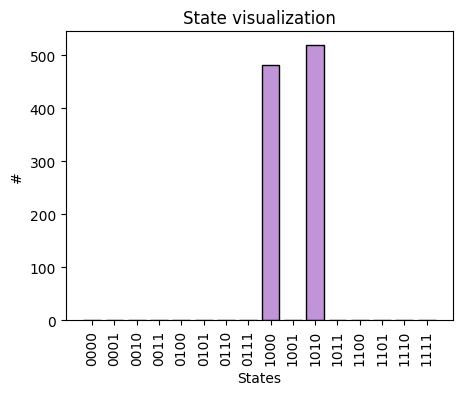

In [9]:
import matplotlib.pyplot as plt
def visualize_states(counter):
    """Plot state's frequencies."""
        
    fig, ax = plt.subplots(figsize=(5, 5 * 6/8))
    ax.set_title('State visualization')
    ax.set_xlabel('States')
    ax.set_ylabel('#')
    plt.xticks(rotation=90)
    n = len(list(counter)[0])
    bitstrings = [format(i, f"0{n}b") for i in range(2**n)]
    for state in bitstrings:
        ax.bar(state, counter[state] if state in counter else 0, color='#C194D8', edgecolor="black")
visualize_states(result.frequencies())

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> Write a quantum circuit with 3 qubits to produce the states $|001\rangle$, $|010\rangle$, and $|111\rangle$.
</div>

#### Let's simulate some entanglement

We can simulate the smallest entangling system in order to reproduce one of the Bell's states

$$ |b_1\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}} \\. $$

To do this, we need to create a two-qubit circuit, lead one of the two qubits to a superposed state using an Hadamard gate and then apply a controlled-NOT gate to the second qubit using the superposed one as control.

<center><img src="../figures/bell.png" alt="drawing" width="400"/></center>

In [10]:
# two qubit circuit to simulate the first Bell's state
c = Circuit(2)
c.add(gates.H(0))
c.add(gates.CNOT(q0=0, q1=1))
c.add(gates.M(*range(2)))

MeasurementResult(qubits=(0, 1), nshots=None)

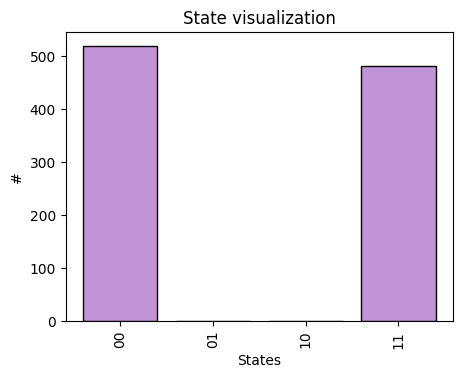

In [11]:
# collect outcome and frequencies
freq = c(nshots=1000).frequencies(binary=True)

# visualize it
visualize_states(freq)

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> implement the quantum circuits needed to prepare the other three Bell's states:
    $$ |b_2\rangle = \frac{|00\rangle - |11\rangle}{\sqrt{2}},\qquad |b_3\rangle = \frac{|10\rangle + |01\rangle}{\sqrt{2}},\qquad |b_4\rangle = \frac{|01\rangle - |10\rangle}{\sqrt{2}} \\. $$
</div>

### Parametrized gates

We can use parametric gates to manipulate the quantum state with some more freedom. 

The most commonly used parametric gates are rotations $R_k(\theta) = \exp [ -i \theta \sigma_k ] $, where $\sigma_k$ is one of the components of the Pauli's vector: $\vec{\sigma}=(I, \sigma_x, \sigma_y, \sigma_z)$.

In [12]:
# a fancier quantum circuit
nqubits = 2
nlayers = 2

c = Circuit(nqubits=nqubits)

for l in range(nlayers):
    for q in range(nqubits):
        # NOTE: the angles are set to zero here!
        c.add(gates.RY(q=q, theta=0))
        c.add(gates.RZ(q=q, theta=0))
    c.add(gates.CNOT(q0=0, q1=nqubits-1))
c.add(gates.M(*range(nqubits)))

c.draw()

0: ─RY─RZ─o─RY─RZ─o─M─
1: ─RY─RZ─X─RY─RZ─X─M─


All the rotational angles are now set to zero, and the final state is equal to the initial state (which is $|0\rangle^{\otimes N}$ by default). We can play with the angles to modify the final state.

(1+0j)|00>


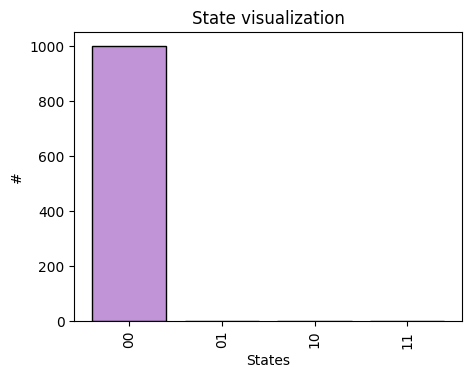

In [13]:
# execute the circuit and collect frequencies
outcome = c(nshots=1000)
freq = outcome.frequencies()

print(outcome)
# visualize the |0> state
visualize_states(freq)

Let's now set some random parameters to see how the distribution changes.

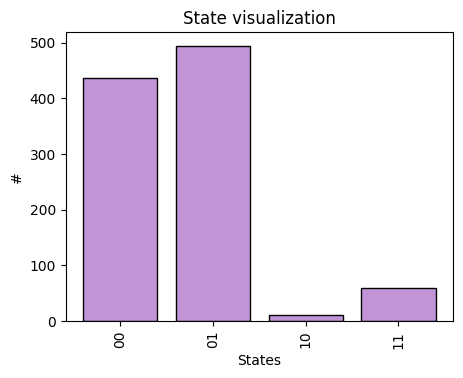

In [14]:
np.random.seed(42)
nparams = len(c.get_parameters())
angles = np.random.randn(nparams)

# set the parameters into the circuit
c.set_parameters(angles)
# execute, collect frequencies and visualize the state
outcome = c(nshots=1000)
freq = outcome.frequencies()

visualize_states(freq)

## Controlled gates
Some controlled gates are already available in Qibo. We can write a generalized controlled gate using `controlled_by`.

In [15]:
nqubits = 3
circuit = Circuit(nqubits)
circuit.add(gates.X(nqubits - 1).controlled_by(*range(nqubits - 1)))
circuit.add(gates.M(*range(nqubits)))
result = circuit(nshots=1000)

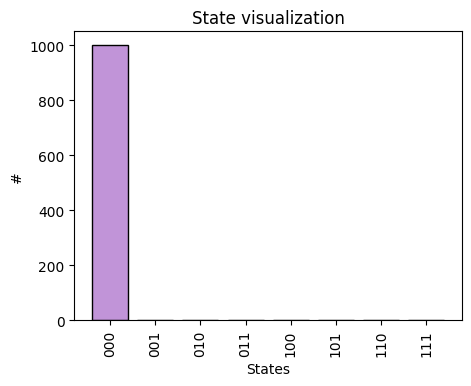

In [16]:
visualize_states(result.frequencies())

Above we see that we measure only the $|000\rangle$ because the first qubit are both in $|0\rangle$.
Let's see what happens if we set both of them to $|1\rangle$ using $X$ gates.

In [17]:
nqubits = 3
circuit = Circuit(nqubits)
for i in range(nqubits-1):
    circuit.add(gates.X(i))
circuit.add(gates.X(nqubits - 1).controlled_by(*range(nqubits - 1)))
circuit.add(gates.M(*range(nqubits)))
circuit.draw()
result = circuit(nshots=1000)

0: ─X─o─M─
1: ─X─o─M─
2: ───X─M─


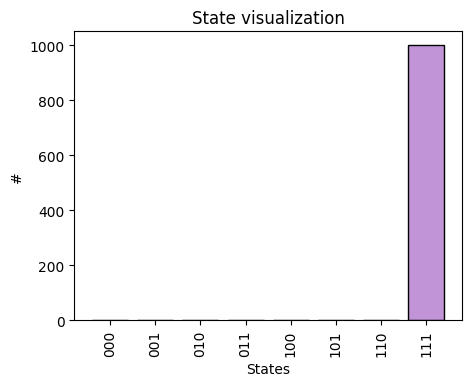

In [18]:
visualize_states(result.frequencies())